In [ ]:
import matplotlib
matplotlib.use('TkAgg')  # Set backend BEFORE importing pyplot

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Button
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import pickle

In [ ]:
# ==========================================
# LOAD PREPROCESSED DATA
# ==========================================
print("=" * 70)
print("LOADING PREPROCESSED DATA")
print("=" * 70)

data_dir = 'Data/preprocessed'

# Load preprocessing info
with open(f'{data_dir}/preprocess_info.pkl', 'rb') as f:
    preprocess_info = pickle.load(f)

# Load preprocessed arrays
train_input_xyz = np.load(f'{data_dir}/train_input_xyz.npy')
train_field_norm = np.load(f'{data_dir}/train_field_norm.npy')
test_input_xyz = np.load(f'{data_dir}/test_input_xyz.npy')
test_field_norm = np.load(f'{data_dir}/test_field_norm.npy')
test_field_output = np.load(f'{data_dir}/test_field_output.npy')
test_scalars = np.load(f'{data_dir}/test_scalars.npy')

# Load normalization statistics
field_min = preprocess_info['field_min']
field_max = preprocess_info['field_max']

print(f"\n✅ Data loaded successfully!")
print(f"   Test samples: {len(test_input_xyz)}")
print(f"   Input shape: {test_input_xyz.shape}")
print(f"   Field output shape: {test_field_norm.shape}")

# Convert to tensors
test_input_tensor = torch.from_numpy(test_input_xyz).float()  # (N_test, 5000, 3)
test_field_tensor = torch.from_numpy(test_field_norm).float()  # (N_test, 5000, 4)

print("=" * 70)

Models

In [ ]:
# ==========================================
# MODEL DEFINITIONS
# ==========================================

class PointNetBaseline(nn.Module):
    def __init__(self):
        super(PointNetBaseline, self).__init__()
        
        # Local Feature Extraction
        self.conv1 = nn.Conv1d(3, 33, 1)
        self.bn1 = nn.BatchNorm1d(33)
        self.conv2 = nn.Conv1d(33, 33, 1)
        self.bn2 = nn.BatchNorm1d(33)
        self.conv3 = nn.Conv1d(33, 33, 1)
        self.bn3 = nn.BatchNorm1d(33)
        
        # Global Feature Extraction
        self.conv4 = nn.Conv1d(33, 67, 1)
        self.bn4 = nn.BatchNorm1d(67)
        self.conv5 = nn.Conv1d(67, 542, 1)
        self.bn5 = nn.BatchNorm1d(542)
        
        # Field Prediction Head
        self.conv6 = nn.Conv1d(575, 271, 1)
        self.bn6 = nn.BatchNorm1d(271)
        self.conv7 = nn.Conv1d(271, 135, 1)
        self.bn7 = nn.BatchNorm1d(135)
        self.conv8 = nn.Conv1d(135, 67, 1)
        self.bn8 = nn.BatchNorm1d(67)
        self.conv9 = nn.Conv1d(67, 4, 1)

    def forward(self, x):
        # Local Features
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        local_features = F.relu(self.bn3(self.conv3(x)))  # (B, 33, N)
        
        # Global Features
        x = F.relu(self.bn4(self.conv4(local_features)))
        x = F.relu(self.bn5(self.conv5(x)))  # (B, 542, N)
        
        # Max Pooling
        global_feature = torch.max(x, 2, keepdim=True)[0]  # (B, 542, 1)
        global_feature_repeated = global_feature.repeat(1, 1, local_features.size(2))
        
        # Concatenate & Predict
        combined = torch.cat([global_feature_repeated, local_features], dim=1)
        x = F.relu(self.bn6(self.conv6(combined)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = torch.sigmoid(self.conv9(x))
        
        return x
    
class PointNetLatent(nn.Module):
    """Extract latent features before the field prediction head"""
    def __init__(self, pointnet_model):
        super().__init__()
        self.conv1 = pointnet_model.conv1
        self.bn1 = pointnet_model.bn1
        self.conv2 = pointnet_model.conv2
        self.bn2 = pointnet_model.bn2
        self.conv3 = pointnet_model.conv3
        self.bn3 = pointnet_model.bn3
        self.conv4 = pointnet_model.conv4
        self.bn4 = pointnet_model.bn4
        self.conv5 = pointnet_model.conv5
        self.bn5 = pointnet_model.bn5

    def forward(self, x):
        # x shape: (B, 3, N)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        local_features = F.relu(self.bn3(self.conv3(x)))  # (B, 33, N)
        
        x = F.relu(self.bn4(self.conv4(local_features)))
        x = F.relu(self.bn5(self.conv5(x)))  # (B, 542, N)
        
        global_feature = torch.max(x, 2, keepdim=True)[0]  # (B, 542, 1)
        global_feature = global_feature.squeeze(-1)
        
        return global_feature

class ScalarHead(nn.Module):
    """MLP head to predict 3 scalars from latent features"""
    def __init__(self, latent_dim=542, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        
        self.fc3 = nn.Linear(hidden_dim // 2, 3)

    def forward(self, latent):
        x = F.relu(self.bn1(self.fc1(latent)))
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.dropout(x, p=0.2, training=self.training)
        
        output = torch.sigmoid(self.fc3(x))
        return output

Prepare models

In [ ]:
# ==========================================
# SETUP DEVICE AND LOAD MODELS
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Load PointNet model
print("\n" + "=" * 70)
print("LOADING PRETRAINED MODELS")
print("=" * 70)

model = PointNetBaseline().to(device)
pointnet_path = 'Data/weight_data/pointnet_best_model.pth'
model.load_state_dict(torch.load(pointnet_path, map_location=device))
model.eval()
print(f"✅ PointNet loaded: {sum(p.numel() for p in model.parameters()):,} parameters")

# Load latent extractor
latent_extractor = PointNetLatent(model).to(device)
latent_extractor.eval()
print(f"✅ Latent extractor ready")

# Load scalar head
scalar_head = ScalarHead().to(device)
scalar_head_path = 'Data/weight_data/scalar_head_best.pth'
scalar_head.load_state_dict(torch.load(scalar_head_path, map_location=device))
scalar_head.eval()
print(f"✅ Scalar head loaded: {sum(p.numel() for p in scalar_head.parameters()):,} parameters")

print("=" * 70)

Device: cuda

LOADING POINTNET BASELINE MODEL
Total parameters: 246,072
✅ Loaded pretrained PointNet from: Data/weight_data/pointnet_best_model.pth

SETTING UP LATENT FEATURE EXTRACTOR
✅ Latent extractor created from pretrained PointNet

LOADING SCALAR HEAD MODEL
Scalar head parameters: 173,059
✅ Loaded scalar head from: Data/weight_data/scalar_head_best.pth

MODELS READY FOR INFERENCE


In [ ]:
# ==========================================
# PREPARE TEST DATA FOR VISUALIZATION
# ==========================================
print("\nPreparing test data for inference...")

# Get denormalization statistics
scalar_columns = preprocess_info['scalar_columns']
scalar_min = preprocess_info['scalar_min']
scalar_max = preprocess_info['scalar_max']

print(f"✅ Test data prepared")
print(f"   Samples: {len(test_input_tensor)}")
print(f"   Field min/max: {field_min} / {field_max}")
print(f"   Scalar min/max: {scalar_min} / {scalar_max}")

Normalize and convert into Tensors:


PREPARE VISUALIZATION
Loaded test sample index: 228


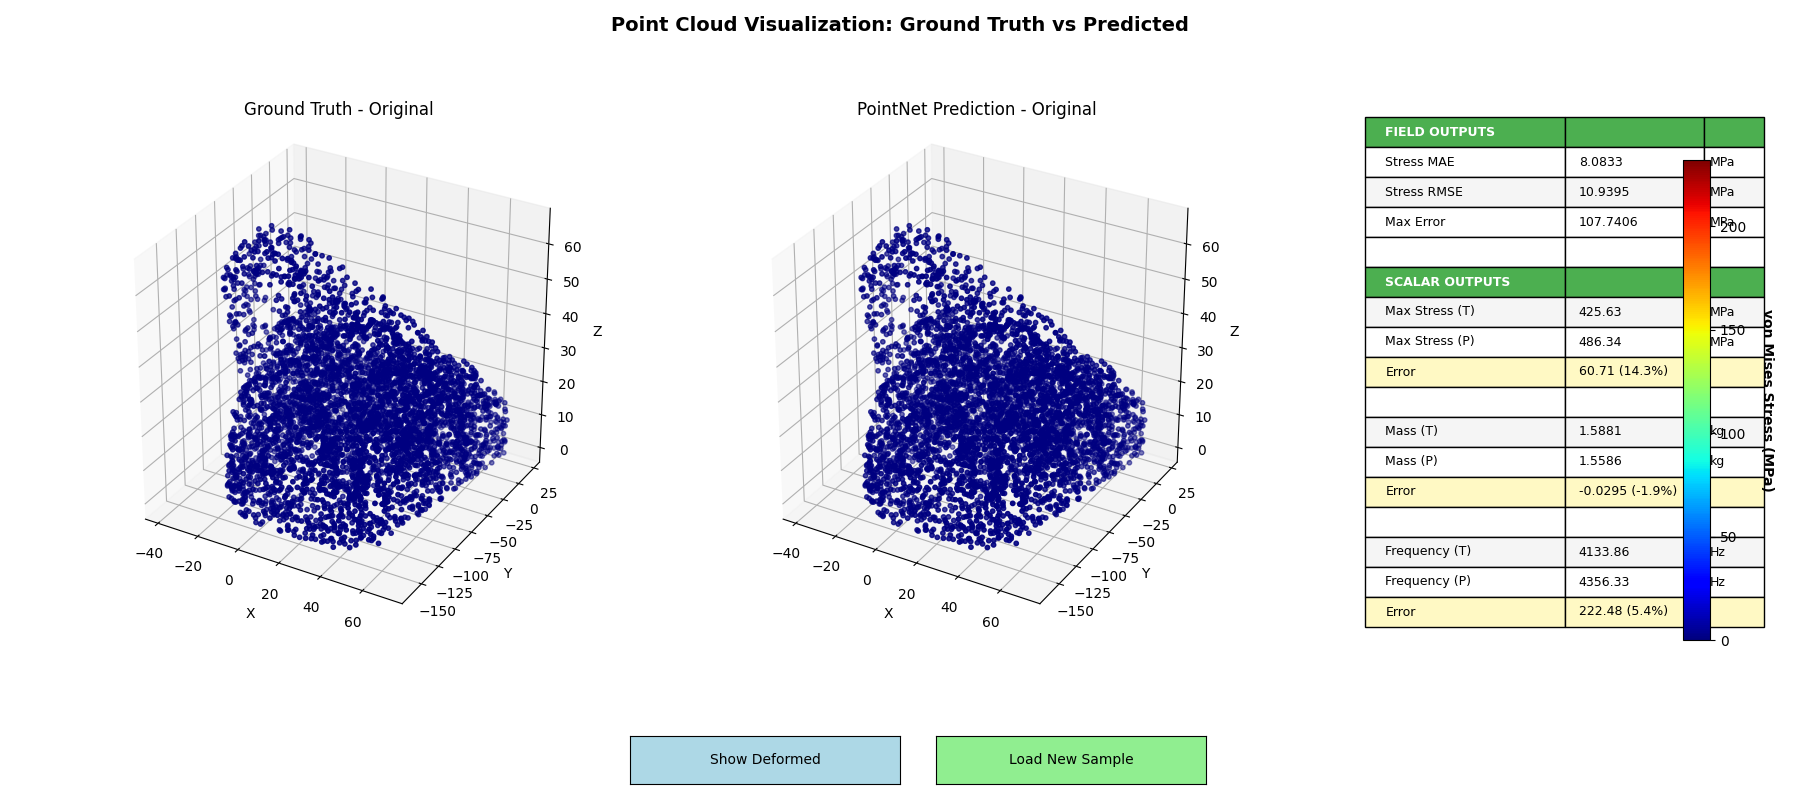


✅ Visualization ready!
   • Click 'Show Deformed' to toggle between original and deformed geometries
   • Click 'Load New Sample' to load a random test sample
   • Metrics table updates automatically on the right panel


In [28]:
# ==========================================
# VISUALIZATION: POINT CLOUD WITH DISPLACEMENTS
# ==========================================
print("\n" + "=" * 70)
print("PREPARE VISUALIZATION")
print("=" * 70)

# Enable interactive mode for Jupyter

# State class for button interaction
class VisualizationState:
    def __init__(self):
        self.deformed = False
        self.test_sample_idx = None
        self.scalar_truth_actual = None
        self.scalar_pred_actual = None
        self.stress_truth_actual = None
        self.stress_pred_actual = None

state = VisualizationState()

def load_sample():
    """Load a new random test sample and update global variables"""
    state.test_sample_idx = np.random.randint(0, len(test_input_tensor))
    print(f"Loaded test sample index: {state.test_sample_idx}")
    
    # Get input and outputs
    sample_input = test_input_tensor[state.test_sample_idx].numpy()
    sample_field_truth = test_field_tensor[state.test_sample_idx].numpy()
    
    # Extract coordinates and displacements from input
    coords_original = sample_input[:, :3]
    
    # Generate predictions using PointNet
    with torch.no_grad():
        sample_coords = sample_input[:, :3]
        sample_input_batch = sample_coords.T[np.newaxis, :, :]
        sample_input_tensor_batch = torch.from_numpy(sample_input_batch).float().to(device)
        sample_field_pred = model(sample_input_tensor_batch).cpu().numpy()[0].T
    
    # Extract latent features for scalar prediction
    latent_features = latent_extractor(sample_input_tensor_batch).detach().cpu().numpy()
    scalar_pred_normalized = scalar_head(torch.from_numpy(latent_features).float().to(device)).detach().cpu().numpy()[0]
    
    # Denormalize scalar predictions
    scalar_pred_actual = scalar_pred_normalized * (scalar_max - scalar_min) + scalar_min
    
    # Extract displacements and stress
    displacements_truth = sample_field_truth[:, :3]
    stress_truth = sample_field_truth[:, 3]
    
    displacements_pred = sample_field_pred[:, :3]
    stress_pred = sample_field_pred[:, 3]
    
    # Denormalize stress to original scale
    stress_truth_actual = stress_truth * (field_max[3] - field_min[3]) + field_min[3]
    stress_pred_actual = stress_pred * (field_max[3] - field_min[3]) + field_min[3]
    
    # Scale displacements
    displacement_scale = 100
    displacements_truth_scaled = displacements_truth * displacement_scale
    displacements_pred_scaled = displacements_pred * displacement_scale
    
    # Get actual scalar values for the sample
    scalar_truth_actual = test_scalars[state.test_sample_idx]
    
    # Store in state for printing
    state.scalar_truth_actual = scalar_truth_actual
    state.scalar_pred_actual = scalar_pred_actual
    state.stress_truth_actual = stress_truth_actual
    state.stress_pred_actual = stress_pred_actual
    
    return (coords_original, displacements_truth_scaled, displacements_pred_scaled,
            stress_truth_actual, stress_pred_actual)

# Load initial sample
coords_original, displacements_truth_scaled, displacements_pred_scaled, \
    stress_truth_actual, stress_pred_actual = load_sample()

# ==========================================
# CREATE INTERACTIVE VISUALIZATION
# ==========================================

fig = plt.figure(figsize=(18, 8))
fig.suptitle('Point Cloud Visualization: Ground Truth vs Predicted', fontsize=14, fontweight='bold')

# Create GridSpec for plots and table
gs = fig.add_gridspec(1, 3, left=0.05, right=0.98, top=0.92, bottom=0.15, 
                       width_ratios=[1, 1, 0.8], wspace=0.3)

# Left plot: Ground truth
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
# Middle plot: Predicted
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
# Right: Table axis
ax_table = fig.add_subplot(gs[0, 2])
ax_table.axis('off')

# Use modern colormap API
cmap = plt.colormaps['jet']
cmax = 232
norm = Normalize(vmin=0, vmax=cmax)
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

# Create colorbar only once (persistent)
cbar_ax = fig.add_axes([0.935, 0.2, 0.015, 0.6])
cbar = fig.colorbar(scalar_map, cax=cbar_ax)
cbar.set_label('von Mises Stress (MPa)', rotation=270, labelpad=20, fontsize=10, fontweight='bold')

# Function to update plots and table
def plot_clouds(deformed=False):
    ax1.clear()
    ax2.clear()
    
    # Coordinates to plot
    if deformed:
        coords_truth = coords_original + displacements_truth_scaled
        coords_pred = coords_original + displacements_pred_scaled
        stress_colors_truth = state.stress_truth_actual
        stress_colors_pred = state.stress_pred_actual
        title_suffix = "Deformed"
    else:
        coords_truth = coords_original
        coords_pred = coords_original
        stress_colors_truth = np.zeros_like(state.stress_truth_actual)
        stress_colors_pred = np.zeros_like(state.stress_pred_actual)
        title_suffix = "Original"
    
    # Plot ground truth
    ax1.scatter(
        coords_truth[:, 0], coords_truth[:, 1], coords_truth[:, 2],
        c=stress_colors_truth, cmap='jet', s=10, vmin=0, vmax=cmax
    )
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(f'Ground Truth - {title_suffix}')
    ax1.set_box_aspect([1, 1, 1])
    
    # Plot predicted
    ax2.scatter(
        coords_pred[:, 0], coords_pred[:, 1], coords_pred[:, 2],
        c=stress_colors_pred, cmap='jet', s=10, vmin=0, vmax=cmax
    )
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_title(f'PointNet Prediction - {title_suffix}')
    ax2.set_box_aspect([1, 1, 1])
    
    # Synchronize camera angles
    ax2.view_init(elev=ax1.elev, azim=ax1.azim)
    
    # Update table on the right
    update_metrics_table()
    
    fig.canvas.draw()

def update_metrics_table():
    """Update the metrics table on the figure"""
    ax_table.clear()
    ax_table.axis('off')
    
    # Calculate errors
    stress_mae = np.mean(np.abs(state.stress_truth_actual - state.stress_pred_actual))
    stress_rmse = np.sqrt(np.mean((state.stress_truth_actual - state.stress_pred_actual) ** 2))
    stress_max_error = np.max(np.abs(state.stress_truth_actual - state.stress_pred_actual))
    
    # Prepare table data
    table_data = []
    table_data.append(['FIELD OUTPUTS', '', ''])
    table_data.append(['Stress MAE', f'{stress_mae:.4f}', 'MPa'])
    table_data.append(['Stress RMSE', f'{stress_rmse:.4f}', 'MPa'])
    table_data.append(['Max Error', f'{stress_max_error:.4f}', 'MPa'])
    table_data.append(['', '', ''])
    table_data.append(['SCALAR OUTPUTS', '', ''])
    
    # Max Diagonal Stress
    stress_error = state.scalar_pred_actual[0] - state.scalar_truth_actual[0]
    stress_error_pct = (stress_error / state.scalar_truth_actual[0]) * 100 if state.scalar_truth_actual[0] != 0 else 0
    table_data.append(['Max Stress (T)', f'{state.scalar_truth_actual[0]:.2f}', 'MPa'])
    table_data.append(['Max Stress (P)', f'{state.scalar_pred_actual[0]:.2f}', 'MPa'])
    table_data.append(['Error', f'{stress_error:.2f} ({stress_error_pct:.1f}%)', ''])
    table_data.append(['', '', ''])
    
    # Mass
    mass_error = state.scalar_pred_actual[1] - state.scalar_truth_actual[1]
    mass_error_pct = (mass_error / state.scalar_truth_actual[1]) * 100 if state.scalar_truth_actual[1] != 0 else 0
    table_data.append(['Mass (T)', f'{state.scalar_truth_actual[1]:.4f}', 'kg'])
    table_data.append(['Mass (P)', f'{state.scalar_pred_actual[1]:.4f}', 'kg'])
    table_data.append(['Error', f'{mass_error:.4f} ({mass_error_pct:.1f}%)', ''])
    table_data.append(['', '', ''])
    
    # Frequency
    freq_error = state.scalar_pred_actual[2] - state.scalar_truth_actual[2]
    freq_error_pct = (freq_error / state.scalar_truth_actual[2]) * 100 if state.scalar_truth_actual[2] != 0 else 0
    table_data.append(['Frequency (T)', f'{state.scalar_truth_actual[2]:.2f}', 'Hz'])
    table_data.append(['Frequency (P)', f'{state.scalar_pred_actual[2]:.2f}', 'Hz'])
    table_data.append(['Error', f'{freq_error:.2f} ({freq_error_pct:.1f}%)', ''])
    
    # Create table
    table = ax_table.table(cellText=table_data, cellLoc='left', loc='center',
                          colWidths=[0.5, 0.35, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.8)
    
    # Style header rows
    for i in [0, 5]:
        for j in range(3):
            table[(i, j)].set_facecolor('#4CAF50')
            table[(i, j)].set_text_props(weight='bold', color='white')
    
    # Style error rows
    for i in [8, 12, 16]:
        for j in range(3):
            table[(i, j)].set_facecolor('#FFF9C4')
    
    # Alternate row colors
    for i in range(len(table_data)):
        if i not in [0, 4, 5, 8, 12, 16]:
            for j in range(3):
                if i % 2 == 0:
                    table[(i, j)].set_facecolor('#F5F5F5')

# Button callback: Toggle deformation
def on_toggle_deformation(event):
    state.deformed = not state.deformed
    plot_clouds(deformed=state.deformed)
    button_text = 'Show Original' if state.deformed else 'Show Deformed'
    button_deform.label.set_text(button_text)

# Button callback: Load new sample
def on_load_new_sample(event):
    global coords_original, displacements_truth_scaled, displacements_pred_scaled
    global stress_truth_actual, stress_pred_actual
    
    coords_original, displacements_truth_scaled, displacements_pred_scaled, \
        stress_truth_actual, stress_pred_actual = load_sample()
    
    # Reset to original state
    state.deformed = False
    button_deform.label.set_text('Show Deformed')
    
    # Redraw
    plot_clouds(deformed=False)

# Add buttons
ax_button_deform = fig.add_axes([0.35, 0.02, 0.15, 0.06])
button_deform = Button(ax_button_deform, 'Show Deformed', color='lightblue', hovercolor='0.975')
button_deform.on_clicked(on_toggle_deformation)

ax_button_load = fig.add_axes([0.52, 0.02, 0.15, 0.06])
button_load = Button(ax_button_load, 'Load New Sample', color='lightgreen', hovercolor='0.975')
button_load.on_clicked(on_load_new_sample)

# Initial plot
plot_clouds(deformed=False)

plt.show()

print("\n✅ Visualization ready!")
print("   • Click 'Show Deformed' to toggle between original and deformed geometries")
print("   • Click 'Load New Sample' to load a random test sample")
print("   • Metrics table updates automatically on the right panel")